## AWS Glue DQ

In [1]:
# 1. Create a python environment

# !conda create -y --name text-to-sql python=3.11.8
# !conda init && activate text-to-sql
# !conda install -n text-to-sql ipykernel --update-deps --force-reinstall -y
# !conda install -c conda-forge ipython-sql

## OR
# !python3 -m venv venv
# !source venv/bin/activate  # On Windows, use `venv\Scripts\activate`

# install ipykernel, which consists of IPython as well
# !pip install ipykernel
# create a kernel that can be used to run notebook commands inside the virtual environment
# !python3 -m ipykernel install --user --name=venv

In [2]:
# 2. Install dependencies

# !pip install -r requirements.txt

### Set up environment variables

In [1]:
# 3. Import necessary libraries and load environment variables

from dotenv import load_dotenv, find_dotenv
import os
import boto3

# loading environment variables that are stored in local file
local_env_filename = 'dev.env'
load_dotenv(find_dotenv(local_env_filename),override=True)

os.environ['REGION'] = os.getenv('REGION')
os.environ['SQL_DATABASE'] = os.getenv('SQL_DATABASE') # LOCAL, SQLALCHEMY, REDSHIFT
os.environ['SQL_DIALECT'] = os.getenv('SQL_DIALECT') # SQlite, PostgreSQL
os.environ['DATABASE_SECRET_NAME'] = os.getenv('DATABASE_SECRET_NAME')
os.environ['S3_BUCKET_NAME'] = os.getenv('S3_BUCKET_NAME')
os.environ['GLUE_IAM_ROLE_ARN'] = os.getenv('GLUE_IAM_ROLE_ARN')


REGION = os.environ['REGION']
SQL_DATABASE = os.environ['SQL_DATABASE']
SQL_DIALECT = os.environ['SQL_DIALECT']
DATABASE_SECRET_NAME = os.environ['DATABASE_SECRET_NAME']
S3_BUCKET_NAME = os.environ['S3_BUCKET_NAME']
GLUE_IAM_ROLE_ARN = os.environ['GLUE_IAM_ROLE_ARN']

MODEL_ID ='us.anthropic.claude-3-5-sonnet-20241022-v2:0'
EVAL_MODEL_ID = MODEL_ID

print(f"Using database: {SQL_DATABASE} with sql dialect: {SQL_DIALECT} in region: {REGION}")

Using database: REDSHIFT with sql dialect: PostgreSQL in region: us-east-1


In [2]:
table_schema = '''
CREATE TABLE public.syn_data
(
    id integer,
    timestamp bigint,
    name character varying(20),
    version smallint DEFAULT 5
)

This table does not have any primary key or any other constraints.

Further, here is a short description for each data type in the table schema:

integer: A 32-bit signed integer. It stores whole numbers in the range of -2,147,483,648 to 2,147,483,647.

bigint: A 64-bit signed integer. It can store much larger whole numbers than an integer, ranging from -9,223,372,036,854,775,808 to 9,223,372,036,854,775,807.

character varying(n): Also known as varchar(n), it stores variable-length strings, with a maximum length of n characters. 
For example, character varying(40) can store a string of up to 40 characters/integers and it can also be an empty string.
The character varying datatype can contain integers, numbers, and strings.
The character varying datatype can be NULL unless otherwise specified.

smallint: A 16-bit signed integer. It takes less space than an integer and is used for smaller numbers in the range of -32,768 to 32,767.

DEFAULT 5: Specifies a default value for the column (in this case, 5) if no value is provided during insert operations.
'''

In [3]:
# Create ground truth dataset for evaluation with columns: inputfile, # of anomalies, list of anomalies
import pandas as pd
import json

# Initialize an empty list to store our data
anomaly_data = []

file = './syn-data/data_anomaly0.csv'
anomalies_list = []  
num_anomalies = 0
anomaly_data.append({
    'inputfile': file,
    'table_schema': table_schema,
    'num_anomalies': num_anomalies,
    'anomalies': json.dumps(anomalies_list) 
})

file = './syn-data/data_anomaly1.csv'
anomalies_list = ['Missing column "version" in all rows']  
num_anomalies = 1
anomaly_data.append({
    'inputfile': file,
    'table_schema': table_schema,
    'num_anomalies': num_anomalies,
    'anomalies': json.dumps(anomalies_list)
})

file = './syn-data/data_anomaly2.csv'
anomalies_list = ['Missing column "version" in all rows','false data type for column "id" in row 5']  
num_anomalies = 2
anomaly_data.append({
    'inputfile': file,
    'table_schema': table_schema,
    'num_anomalies': num_anomalies,
    'anomalies': json.dumps(anomalies_list)  
})

file = './syn-data/data_anomaly3.csv'
anomalies_list = ['Missing column "version" in all rows','false data type for column "id" in row 5', 'string value for column "name" in row 4 exceeds character limit']  
num_anomalies = 2
anomaly_data.append({
    'inputfile': file,
    'table_schema': table_schema,
    'num_anomalies': num_anomalies,
    'anomalies': json.dumps(anomalies_list)  
})

# Create the DataFrame
df_anomalies_eval = pd.DataFrame(anomaly_data)

# Display the DataFrame
print(df_anomalies_eval)

# save df as jsonl
df_anomalies_eval.to_json('./eval/anomalies_summary.jsonl', orient='records', lines=True)


                      inputfile  \
0  ./syn-data/data_anomaly0.csv   
1  ./syn-data/data_anomaly1.csv   
2  ./syn-data/data_anomaly2.csv   
3  ./syn-data/data_anomaly3.csv   

                                        table_schema  num_anomalies  \
0  \nCREATE TABLE public.syn_data\n(\n    id inte...              0   
1  \nCREATE TABLE public.syn_data\n(\n    id inte...              1   
2  \nCREATE TABLE public.syn_data\n(\n    id inte...              2   
3  \nCREATE TABLE public.syn_data\n(\n    id inte...              2   

                                           anomalies  
0                                                 []  
1         ["Missing column \"version\" in all rows"]  
2  ["Missing column \"version\" in all rows", "fa...  
3  ["Missing column \"version\" in all rows", "fa...  


In [11]:
# helper method to parse xml string to dict and print dict
def parse_xml_to_dict(xml_string):
    # parse xml string (result[0]) to dict and print dict
    import xmltodict
    import json

    try:
        # Parse the XML string to a Python dictionary
        parsed_result = xmltodict.parse(xml_string)
        
        # Print the dictionary
        print(json.dumps(parsed_result, indent=4))
    except xmltodict.expat.ExpatError as e:
        print(f"Error parsing XML: {e}")
    except IndexError:
        print("Error: result[0] is not available. Make sure 'result' is not empty.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [4]:
# zero shot prompting

PROMPT_TEMPLATE_1 = '''
You are an expert data analyst specializing in anomaly detection. 
Your task is to analyze the attached dataset and identify any irregularities or inconsistencies. Return your findings in valid XML format.

Table Schema:
{TABLE_SCHEMA}

Objectives:
1. Examine the data for compatibility with the provided schema.
2. Identify and report any anomalies that would break the table schema, such as:
   - Data type mismatches
   - Missing columns
   - Missing values if the column is not nullable or does not allow an empty string
   - Duplicate entries
3. Provide a concise description of the identified anomaly, including a reference to the specific anomaly row / column value.
4. If applicable, suggest potential causes or implications of the detected anomalies.
5. If the anomaly is with regards to a data type mismatch, then include the anomaly only once in the list of anomalies.

The dataset is attached.

Please analyze the data thoroughly.

Return the response in the following XML format, ensuring that all special characters are properly escaped and the XML is well-formed:

<?xml version="1.0" encoding="UTF-8"?>
<anomalies>
    <anomaly>
        <anomalyDescription>concise description of the identified anomaly</anomalyDescription>
        <anomalyValues>anomaly values</anomalyValues>
        <impactedColumn>impacted column from table schema</impactedColumn>
        <impactedRow>impacted row data</impactedRow>
        <recommendation><recommendation for fixing the anomaly</recommendation>
    </anomaly>
    <!-- Add more <anomaly> elements as needed -->
</anomalies>

Ensure that:
1. The XML declaration is included at the beginning.
2. All text content is wrapped in CDATA sections to prevent issues with special characters.
3. The XML is properly indented for readability.
4. There are no unclosed tags or other XML syntax errors.
5. If multiple anomalies are found, include multiple <anomaly> elements within the <anomalies> root element.
6. If no anomalies are found, return an empty <anomalies> element.
7. Only include XML and nothing else in the response
'''

In [6]:
# test PROMPT_TEMPLATE_1
prompt = PROMPT_TEMPLATE_1.format(TABLE_SCHEMA=table_schema)
from utils.bedrock import BedrockLLMWrapper
bedrock = BedrockLLMWrapper(debug=False, max_token_count=4096, model_id=MODEL_ID)
csv_file_path='syn-data/data_anomaly1.csv'
result = bedrock.generate(prompt, attachment_file=csv_file_path)
# pretty print json result
import json
print(json.dumps(result, indent=4))

[
    "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<anomalies>\n    <anomaly>\n        <anomalyDescription><![CDATA[Missing version column value in all rows]]></anomalyDescription>\n        <anomalyValues><![CDATA[Column 'version' is empty for all records]]></anomalyValues>\n        <impactedColumn><![CDATA[version]]></impactedColumn>\n        <impactedRow><![CDATA[All rows]]></impactedRow>\n        <recommendation><![CDATA[While the schema specifies a default value of 5 for the version column, it's recommended to explicitly include the version column in the data to maintain data clarity and consistency. If intentionally omitted, the default value of 5 will be used during insertion.]]></recommendation>\n    </anomaly>\n    <anomaly>\n        <anomalyDescription><![CDATA[Timestamp values are Unix timestamps in milliseconds, which may exceed the maximum value for a PostgreSQL bigint]]></anomalyDescription>\n        <anomalyValues><![CDATA[1683849600000, 1683849660000, 1683849720000, 1683

In [12]:
parse_xml_to_dict(result[0])

{
    "anomalies": {
        "anomaly": {
            "anomalyDescription": "Missing column 'version' in the dataset which is defined in the table schema",
            "anomalyValues": "Column 'version' is completely missing from the data",
            "impactedColumn": "version",
            "impactedRow": "All rows",
            "recommendation": "Add the 'version' column to the dataset. Since the schema defines a DEFAULT value of 5, this might not cause insertion errors, but the column should be present for data completeness and consistency."
        }
    }
}


In [9]:
# CoT prompting

PROMPT_TEMPLATE_2 = '''
You are an expert data analyst specializing in anomaly detection. 
Your task is to analyze the attached dataset and identify any irregularities or inconsistencies. Return your findings in valid XML format.

Table Schema:
{TABLE_SCHEMA}

Instructions:
1. Determine the actual schema of the provided data.
2. Identify and report any anomalies that would break the table schema, such as:
   - Data type mismatches
   - Missing columns
   - Missing values if the column is not nullable or does not allow an empty string
   - Duplicate entries
3. Provide a concise summary of the anomaly, highlighting the anomaly row / column value.
4. If applicable, suggest potential causes or implications of the detected anomalies.
5. Review and verify each identified anomaly individually against the provided table schema definition and data type definition again and ensure that this is indeed an anomaly.
6. If the anomaly is with regards to a data type mismatch, then include the anomaly only once in the list of anomalies.

Analyze the attached dataset thoroughly.

Return the response in the following XML format, ensuring that all special characters are properly escaped and the XML is well-formed:

<?xml version="1.0" encoding="UTF-8"?>
<anomalies>
    <anomaly>
        <anomalyDescription>concise description of the identified anomaly</anomalyDescription>
        <anomalyValues>anomaly values</anomalyValues>
        <impactedColumn>impacted column from table schema</impactedColumn>
        <impactedRow>impacted row data</impactedRow>
        <recommendation><recommendation for fixing the anomaly</recommendation>
    </anomaly>
    <!-- Add more <anomaly> elements as needed -->
</anomalies>

Ensure that:
1. The XML declaration is included at the beginning.
2. All text content is wrapped in CDATA sections to prevent issues with special characters.
3. The XML is properly indented for readability.
4. There are no unclosed tags or other XML syntax errors.
5. If multiple anomalies are found, include multiple <anomaly> elements within the <anomalies> root element.
6. If no anomalies are found, return an empty <anomalies> element.
7. Only include XML and nothing else in the response.
'''


In [18]:
# test PROMPT_TEMPLATE_2
prompt = PROMPT_TEMPLATE_2.format(TABLE_SCHEMA=table_schema)
from utils.bedrock import BedrockLLMWrapper
bedrock = BedrockLLMWrapper(debug=False, max_token_count=4096, model_id=MODEL_ID)
csv_file_path='syn-data/data_anomaly3.csv'
result = bedrock.generate(prompt, attachment_file=csv_file_path)
# pretty print json result
import json
print(json.dumps(result, indent=4))

[
    "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<anomalies>\n    <anomaly>\n        <anomalyDescription><![CDATA[Column 'version' is missing from the provided data but exists in table schema]]></anomalyDescription>\n        <anomalyValues><![CDATA[Column not present in data]]></anomalyValues>\n        <impactedColumn><![CDATA[version]]></impactedColumn>\n        <impactedRow><![CDATA[All rows]]></impactedRow>\n        <recommendation><![CDATA[Add the 'version' column to the data. If not provided, it will use the default value of 5 as per schema definition.]]></recommendation>\n    </anomaly>\n    <anomaly>\n        <anomalyDescription><![CDATA[ID contains non-integer characters, violating integer data type constraint]]></anomalyDescription>\n        <anomalyValues><![CDATA[5err]]></anomalyValues>\n        <impactedColumn><![CDATA[id]]></impactedColumn>\n        <impactedRow><![CDATA[5err,1683849840000,Robert Wilson]]></impactedRow>\n        <recommendation><![CDATA[Remove non-numeri

In [19]:
parse_xml_to_dict(result[0])

{
    "anomalies": {
        "anomaly": [
            {
                "anomalyDescription": "Column 'version' is missing from the provided data but exists in table schema",
                "anomalyValues": "Column not present in data",
                "impactedColumn": "version",
                "impactedRow": "All rows",
                "recommendation": "Add the 'version' column to the data. If not provided, it will use the default value of 5 as per schema definition."
            },
            {
                "anomalyDescription": "ID contains non-integer characters, violating integer data type constraint",
                "anomalyValues": "5err",
                "impactedColumn": "id",
                "impactedRow": "5err,1683849840000,Robert Wilson",
                "recommendation": "Remove non-numeric characters from ID or correct the value to be a valid integer."
            },
            {
                "anomalyDescription": "Name exceeds maximum length of 20 character

In [20]:
# few shot prompting
few_shot_examples = '''
<anomalies>
    <anomaly>
        <anomalyDescription><![CDATA[Column 'timestamp' is missing from the provided data but exists in table schema]]></anomalyDescription>
        <anomalyValues><![CDATA[Column not present in data]]></anomalyValues>
        <impactedColumn><![CDATA[timestamp]]></impactedColumn>
        <impactedRow><![CDATA[All rows]]></impactedRow>
        <recommendation><![CDATA[Add the 'timestamp' column to the data. This is a required field with no default value.]]></recommendation>
    </anomaly>
    <anomaly>
        <anomalyDescription><![CDATA[Age contains non-integer characters, violating integer data type constraint]]></anomalyDescription>
        <anomalyValues><![CDATA[25y]]></anomalyValues>
        <impactedColumn><![CDATA[age]]></impactedColumn>
        <impactedRow><![CDATA[1,25y,John Smith,1684123456789]]></impactedRow>
        <recommendation><![CDATA[Remove non-numeric characters from age field or provide a valid integer value.]]></recommendation>
    </anomaly>
    <anomaly>
        <anomalyDescription><![CDATA[Email address exceeds maximum length of 50 characters specified in schema]]></anomalyDescription>
        <anomalyValues><![CDATA[this.is.a.very.long.email.address.that.exceeds.the.maximum.length@verylongdomain.com]]></anomalyValues>
        <impactedColumn><![CDATA[email]]></impactedColumn>
        <impactedRow><![CDATA[2,1684123456789,this.is.a.very.long.email.address.that.exceeds.the.maximum.length@verylongdomain.com]]></impactedRow>
        <recommendation><![CDATA[Truncate or modify the email address to fit within 50 characters as specified in the character varying(50) constraint.]]></recommendation>
    </anomaly>
</anomalies>
'''

PROMPT_TEMPLATE_3 = '''You are an expert data analyst specializing in anomaly detection. 
Your task is to analyze the attached dataset and identify any irregularities or inconsistencies. Return your findings in valid XML format.

Table Schema:
{TABLE_SCHEMA}

Instructions:
1. Determine the actual schema of the provided data.
2. Identify and report any anomalies that would break the table schema, such as:
   - Data type mismatches
   - Missing columns
   - Missing values if the column is not nullable or does not allow an empty string
   - Duplicate entries
3. Provide a concise summary of the anomaly, highlighting the anomaly row / column value.
4. If applicable, suggest potential causes or implications of the detected anomalies.
5. If the anomaly is with regards to a data type mismatch, then include the anomaly only once in the list of anomalies.


Here are some examples of anomalies:
{FEW_SHOT_EXAMPLES}

Analyze the attached dataset thoroughly.

Return the response in the following XML format, ensuring that all special characters are properly escaped and the XML is well-formed:

<?xml version="1.0" encoding="UTF-8"?>
<anomalies>
    <anomaly>
        <anomalyDescription>concise description of the identified anomaly</anomalyDescription>
        <anomalyValues>anomaly values</anomalyValues>
        <impactedColumn>impacted column from table schema</impactedColumn>
        <impactedRow>impacted row data</impactedRow>
        <recommendation><recommendation for fixing the anomaly</recommendation>
    </anomaly>
    <!-- Add more <anomaly> elements as needed -->
</anomalies>

Ensure that:
1. The XML declaration is included at the beginning.
2. All text content is wrapped in CDATA sections to prevent issues with special characters.
3. The XML is properly indented for readability.
4. There are no unclosed tags or other XML syntax errors.
5. If multiple anomalies are found, include multiple <anomaly> elements within the <anomalies> root element.
6. If no anomalies are found, return an empty <anomalies> element.
7. Only include XML and nothing else in the response.
'''

In [21]:
# test PROMPT_TEMPLATE_3
prompt = PROMPT_TEMPLATE_3.format(TABLE_SCHEMA=table_schema,FEW_SHOT_EXAMPLES=few_shot_examples)
from utils.bedrock import BedrockLLMWrapper
bedrock = BedrockLLMWrapper(debug=False, max_token_count=4096, model_id=MODEL_ID)
csv_file_path='syn-data/data_anomaly3.csv'
result = bedrock.generate(prompt, attachment_file=csv_file_path)
# pretty print json result
import json
print(json.dumps(result, indent=4))

[
    "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<anomalies>\n    <anomaly>\n        <anomalyDescription><![CDATA[Column 'version' is missing from the provided data but exists in table schema]]></anomalyDescription>\n        <anomalyValues><![CDATA[Column not present in data]]></anomalyValues>\n        <impactedColumn><![CDATA[version]]></impactedColumn>\n        <impactedRow><![CDATA[All rows]]></impactedRow>\n        <recommendation><![CDATA[Add the 'version' column to the data. If not provided, it will use the default value of 5 as per schema definition.]]></recommendation>\n    </anomaly>\n    <anomaly>\n        <anomalyDescription><![CDATA[ID contains non-integer characters, violating integer data type constraint]]></anomalyDescription>\n        <anomalyValues><![CDATA[5err]]></anomalyValues>\n        <impactedColumn><![CDATA[id]]></impactedColumn>\n        <impactedRow><![CDATA[5err,1683849840000,Robert Wilson]]></impactedRow>\n        <recommendation><![CDATA[Remove non-numeri

In [22]:
parse_xml_to_dict(result[0])

{
    "anomalies": {
        "anomaly": [
            {
                "anomalyDescription": "Column 'version' is missing from the provided data but exists in table schema",
                "anomalyValues": "Column not present in data",
                "impactedColumn": "version",
                "impactedRow": "All rows",
                "recommendation": "Add the 'version' column to the data. If not provided, it will use the default value of 5 as per schema definition."
            },
            {
                "anomalyDescription": "ID contains non-integer characters, violating integer data type constraint",
                "anomalyValues": "5err",
                "impactedColumn": "id",
                "impactedRow": "5err,1683849840000,Robert Wilson",
                "recommendation": "Remove non-numeric characters from ID or correct the value to be a valid integer."
            },
            {
                "anomalyDescription": "Name exceeds maximum length of 20 character

In [23]:
# self-reflection with prompt decomposition
# a. first identify anomalies
# b. then reflect "are you sure?"
# c. standardize response

# few shot prompting
few_shot_examples = '''
<anomalies>
    <anomaly>
        <anomalyDescription><![CDATA[Column 'timestamp' is missing from the provided data but exists in table schema]]></anomalyDescription>
        <anomalyValues><![CDATA[Column not present in data]]></anomalyValues>
        <impactedColumn><![CDATA[timestamp]]></impactedColumn>
        <impactedRow><![CDATA[All rows]]></impactedRow>
        <recommendation><![CDATA[Add the 'timestamp' column to the data. This is a required field with no default value.]]></recommendation>
    </anomaly>
    <anomaly>
        <anomalyDescription><![CDATA[Age contains non-integer characters, violating integer data type constraint]]></anomalyDescription>
        <anomalyValues><![CDATA[25y]]></anomalyValues>
        <impactedColumn><![CDATA[age]]></impactedColumn>
        <impactedRow><![CDATA[1,25y,John Smith,1684123456789]]></impactedRow>
        <recommendation><![CDATA[Remove non-numeric characters from age field or provide a valid integer value.]]></recommendation>
    </anomaly>
    <anomaly>
        <anomalyDescription><![CDATA[Email address exceeds maximum length of 50 characters specified in schema]]></anomalyDescription>
        <anomalyValues><![CDATA[this.is.a.very.long.email.address.that.exceeds.the.maximum.length@verylongdomain.com]]></anomalyValues>
        <impactedColumn><![CDATA[email]]></impactedColumn>
        <impactedRow><![CDATA[2,1684123456789,this.is.a.very.long.email.address.that.exceeds.the.maximum.length@verylongdomain.com]]></impactedRow>
        <recommendation><![CDATA[Truncate or modify the email address to fit within 50 characters as specified in the character varying(50) constraint.]]></recommendation>
    </anomaly>
</anomalies>
'''

PROMPT_TEMPLATE_4 = '''You are an expert data analyst specializing in anomaly detection. 
Your task is to analyze the attached dataset and identify any irregularities or inconsistencies. Return your findings in valid XML format.

Table Schema:
{TABLE_SCHEMA}

Instructions:
1. Determine the actual schema of the provided data.
2. Identify and report any anomalies that would break the table schema, such as:
   - Data type mismatches
   - Missing columns
   - Missing values if the column is not nullable or does not allow an empty string
   - Duplicate entries
3. Provide a concise summary of the anomaly, highlighting the anomaly row / column value.
4. If applicable, suggest potential causes or implications of the detected anomalies.
5. If the anomaly is with regards to a data type mismatch, then include the anomaly only once in the list of anomalies.


Here are some examples of anomalies:
{FEW_SHOT_EXAMPLES}

Analyze the attached dataset thoroughly.

'''

PROMPT_TEMPLATE_REFLECT = '''
{PRIOR_RESPONSE}

Reflect on your previous response. Are you sure?
'''

PROMPT_TEMPLATE_STANDARDIZE = '''
{PRIOR_RESPONSE}

Finalize and standardize your response.
Return the response in the following XML format, ensuring that all special characters are properly escaped and the XML is well-formed:

<?xml version="1.0" encoding="UTF-8"?>
<anomalies>
    <anomaly>
        <anomalyDescription>concise description of the identified anomaly</anomalyDescription>
        <anomalyValues>anomaly values</anomalyValues>
        <impactedColumn>impacted column from table schema</impactedColumn>
        <impactedRow>impacted row data</impactedRow>
        <recommendation><recommendation for fixing the anomaly</recommendation>
    </anomaly>
    <!-- Add more <anomaly> elements as needed -->
</anomalies>

Ensure that:
1. The XML declaration is included at the beginning.
2. All text content is wrapped in CDATA sections to prevent issues with special characters.
3. The XML is properly indented for readability.
4. There are no unclosed tags or other XML syntax errors.
5. If multiple anomalies are found, include multiple <anomaly> elements within the <anomalies> root element.
6. If no anomalies are found, return an empty <anomalies> element.
7. Only include XML and nothing else in the response. 
'''


In [24]:
# test self reflection with prompt decomposition
prompt = PROMPT_TEMPLATE_4.format(TABLE_SCHEMA=table_schema,FEW_SHOT_EXAMPLES=few_shot_examples)
from utils.bedrock import BedrockLLMWrapper
bedrock = BedrockLLMWrapper(debug=False, max_token_count=4096, model_id=MODEL_ID)
csv_file_path='syn-data/data_anomaly1.csv'
result = bedrock.generate(prompt, attachment_file=csv_file_path)

prompt2 = PROMPT_TEMPLATE_REFLECT.format(PRIOR_RESPONSE=result[0])
result2 = bedrock.generate(prompt2)

prompt3 = PROMPT_TEMPLATE_STANDARDIZE.format(PRIOR_RESPONSE=result2[0])
result3 = bedrock.generate(prompt3)
# pretty print json result
import json
print(json.dumps(result3, indent=4))

[
    "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<anomalies>\n    <anomaly>\n        <anomalyDescription><![CDATA[Version column missing from dataset but has DEFAULT constraint]]></anomalyDescription>\n        <anomalyValues><![CDATA[NULL]]></anomalyValues>\n        <impactedColumn><![CDATA[version]]></impactedColumn>\n        <impactedRow><![CDATA[All rows]]></impactedRow>\n        <recommendation><![CDATA[No action required. DEFAULT 5 constraint will handle missing values during insertion.]]></recommendation>\n    </anomaly>\n    <anomaly>\n        <anomalyDescription><![CDATA[Timestamp values stored as Unix epoch milliseconds]]></anomalyDescription>\n        <anomalyValues><![CDATA[1683849600000, etc.]]></anomalyValues>\n        <impactedColumn><![CDATA[timestamp]]></impactedColumn>\n        <impactedRow><![CDATA[All rows]]></impactedRow>\n        <recommendation><![CDATA[No action required. Values are valid and properly stored as bigint.]]></recommendation>\n    </anomaly>\n</ano

In [25]:
parse_xml_to_dict(result3[0])

{
    "anomalies": {
        "anomaly": [
            {
                "anomalyDescription": "Version column missing from dataset but has DEFAULT constraint",
                "anomalyValues": "NULL",
                "impactedColumn": "version",
                "impactedRow": "All rows",
                "recommendation": "No action required. DEFAULT 5 constraint will handle missing values during insertion."
            },
            {
                "anomalyDescription": "Timestamp values stored as Unix epoch milliseconds",
                "anomalyValues": "1683849600000, etc.",
                "impactedColumn": "timestamp",
                "impactedRow": "All rows",
                "recommendation": "No action required. Values are valid and properly stored as bigint."
            }
        ]
    }
}


In [26]:
# System Prompt
RUBRIC_SYSTEM_PROMPT = """You are an expert judge evaluating the results of an anomaly detection engine.
Your task is to evaluate the anomaly detection results based on the provided ground truth data and table schema using the criteria provided.
Evaluation Criteria (Score either 0 or 1 for each, total score is the sum):
1. Accuracy: Is the anomaly detection response factually correct based on the given dataset and table schema?
2. Precision: Does the anomaly detection response correctly identify all anomalies present in the ground truth dataset?
3. Clarity: Is the anomaly detection response easy to understand and follow?
Your role is to provide a fair and thorough evaluation for each criterion, explaining your reasoning clearly."""

# User Prompt
RUBRIC_EVAL_PROMPT = """Please evaluate the following anomaly detection response and attached dataset

Anomaly detection result:
{anomaly_detection_response}


Table schema:
{table_schema}


Ground truth data:
{ground_truth_anomalies}


Evaluation Steps:
1. Carefully read the provided table schema, dataset, and anomaly detection result.
2. For each evaluation criterion, assign a score of either 0 or 1:
   - Precision
   - Accuracy
   - Clarity
3. Provide a clear explanation for each score, referencing specific aspects of the response.
4. Calculate the total score by adding up the points awarded (minimum 0, maximum 3).
5. Present your evaluation inside <thinking></thinking> tags.
6. Include individual criterion scores (0 or 1) in the thinking tags and the total score inside <score></score> tags.
7. Based on the results of the above evaluation, classify the anomaly detection result as either a true positive (TP), false positive (FP), true negative (TN), or false negative (FN) in the following XML format:
   <classification>TP, FP, TN, FN</classification>
8. Ensure your response is valid XML and provides a comprehensive evaluation.

Example Output Format:
<thinking>
Precision: 1 - The response included all anomalies present in the ground truth dataset.
Accuracy: 0 - The response introduced facts that were not present in the dataset and table schema.
Clarity: 1 - The response is clear and easy to follow.
</thinking>
<score>2</score>
<classification>FP</classification>
Please provide your detailed evaluation."""

In [27]:
from utils.evaluation import EvaluationTaskRunner

eval_results1: pd.DataFrame = EvaluationTaskRunner(df_anomalies_eval,
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                 prompt_template_1=PROMPT_TEMPLATE_1,
                 prompt_eval_system=RUBRIC_SYSTEM_PROMPT,
                 prompt_eval_template=RUBRIC_EVAL_PROMPT
                 ).run()

In [28]:
from utils.evaluation import EvaluationTaskRunner

eval_results2: pd.DataFrame = EvaluationTaskRunner(df_anomalies_eval,
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                 prompt_template_1=PROMPT_TEMPLATE_2,

                 prompt_eval_system=RUBRIC_SYSTEM_PROMPT,
                 prompt_eval_template=RUBRIC_EVAL_PROMPT
                 ).run()

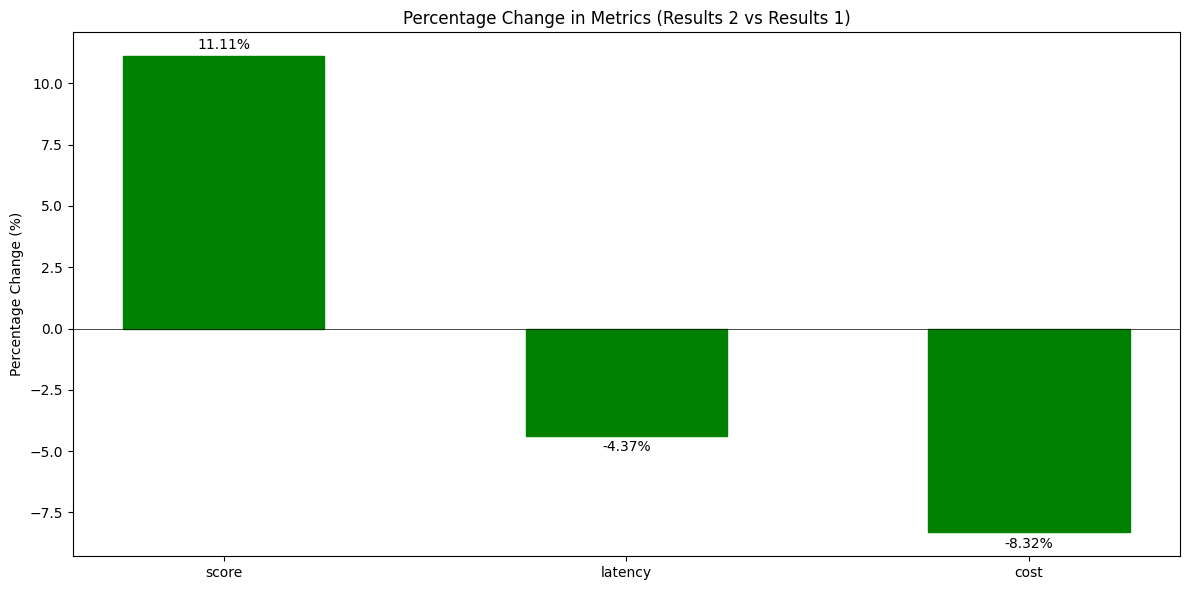

In [29]:
from utils.util import Util
util = Util()
util.compare_results(eval_results1, eval_results2, metrics=['score', 'latency', 'cost'])


In [30]:
from utils.evaluation import EvaluationTaskRunner

eval_results3: pd.DataFrame = EvaluationTaskRunner(df_anomalies_eval,
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                 prompt_template_1=PROMPT_TEMPLATE_3,
                 few_shot_examples=few_shot_examples,
                 prompt_eval_system=RUBRIC_SYSTEM_PROMPT,
                 prompt_eval_template=RUBRIC_EVAL_PROMPT
                 ).run()

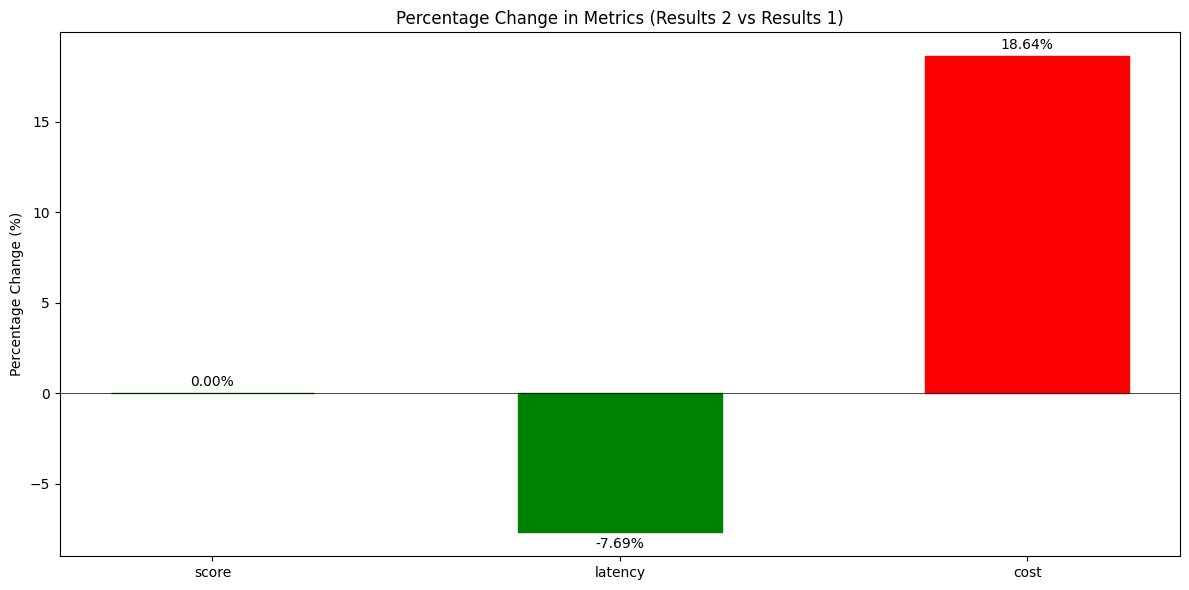

In [31]:
from utils.util import Util
util = Util()
util.compare_results(eval_results2, eval_results3, metrics=['score', 'latency', 'cost'])


In [32]:
from utils.evaluation import EvaluationTaskRunner

eval_results4: pd.DataFrame = EvaluationTaskRunner(df_anomalies_eval,
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                 prompt_template_1=PROMPT_TEMPLATE_4,
                 prompt_template_2=PROMPT_TEMPLATE_REFLECT,
                 prompt_template_3=PROMPT_TEMPLATE_STANDARDIZE,
                 few_shot_examples=few_shot_examples,
                 prompt_eval_system=RUBRIC_SYSTEM_PROMPT,
                 prompt_eval_template=RUBRIC_EVAL_PROMPT
                 ).run()

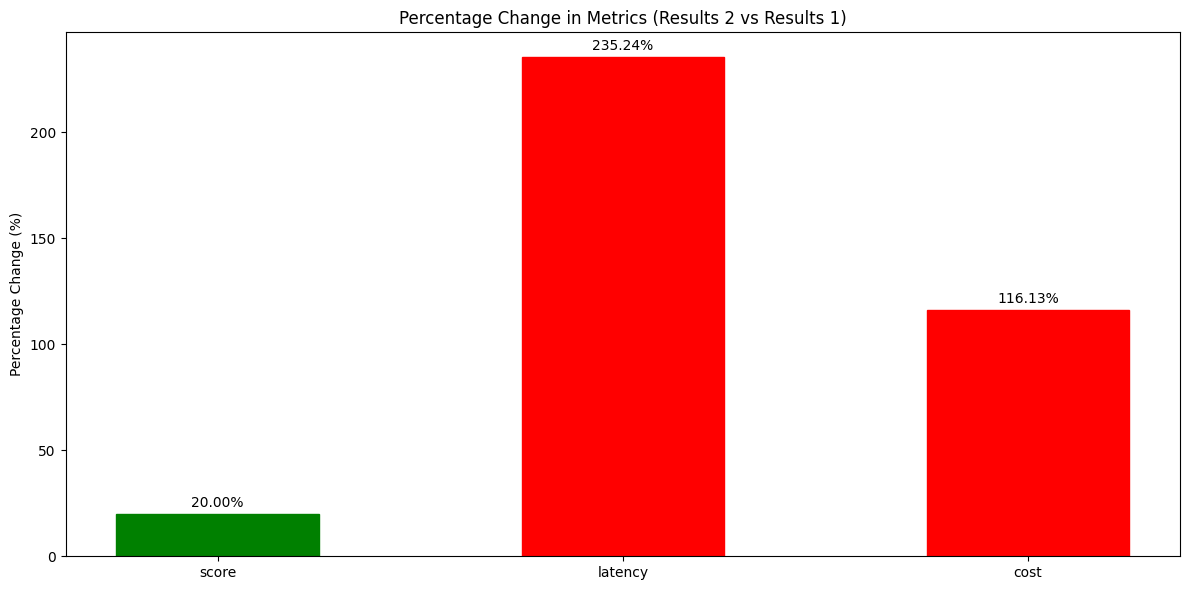

In [33]:
from utils.util import Util
util = Util()
util.compare_results(eval_results3, eval_results4, metrics=['score', 'latency', 'cost'])


In [34]:
# Review eval results
print('eval_results1: zero-shot')
util.show_df(eval_results1)
print('eval_results2: CoT')
util.show_df(eval_results2)
print('eval_results3: few-shot')
util.show_df(eval_results3)
print('eval_results4: few-shot with reflection & decomposition')
util.show_df(eval_results4)


eval_results1: zero-shot


InputFile,Reasoning,Score,Classification
./syn-data/data_anomaly0.csv,"Precision: 0 - The response identifies anomalies based on an incorrect interpretation of the schema. The smallint DEFAULT 5 means that if no value is provided during insertion, 5 will be used - it does not mean 5 is the maximum allowed value. A smallint can store values up to 32,767, so values of 6 and 7 are perfectly valid.\n\nAccuracy: 0 - The anomaly detection response is factually incorrect. It misinterprets the DEFAULT constraint as a maximum value constraint. The version values of 6 and 7 in the dataset are well within the valid range for smallint (-32,768 to 32,767) and do not violate any schema constraints.\n\nClarity: 1 - Despite being incorrect, the response is well-structured, clear, and easy to understand. It provides detailed information including descriptions, impacted values, affected rows, and recommendations in a organized XML format.",1,FP
./syn-data/data_anomaly1.csv,"Precision: 1 - The anomaly detection correctly identified the missing version column values, which matches the ground truth data. The response accurately captured this key anomaly.\n\nAccuracy: 0 - While the first anomaly about missing version values is correct, the second anomaly regarding timestamp values being ""anomalous"" because they are in milliseconds is not justified. The bigint data type can easily accommodate millisecond-precision timestamps, and there's nothing in the schema or ground truth data suggesting this is problematic. This represents an incorrect inference.\n\nClarity: 1 - The response is well-structured in XML format with clear descriptions, impacted columns/rows, and specific recommendations. Each anomaly is thoroughly documented with clear explanations and specific values affected.",2,FP
./syn-data/data_anomaly2.csv,"Precision: 1 - The anomaly detection response correctly identified both anomalies present in the ground truth dataset: the missing ""version"" column and the invalid ID format in row 5. The findings exactly match the ground truth data.\n\nAccuracy: 1 - The response is factually correct based on the given dataset and table schema. The ID column should contain integers according to the schema, and ""5err"" violates this requirement. Additionally, the version column is indeed missing from the dataset despite being defined in the schema. The recommendations provided are also accurate, mentioning the correct integer range and the DEFAULT value of 5 for the version column.\n\nClarity: 1 - The response is well-structured in XML format with clear descriptions, impacted values, affected columns, and specific recommendations. Each anomaly is clearly separated and includes all relevant details. The descriptions are concise yet informative, making it easy for users to understand the issues and how to resolve them.",3,TP
./syn-data/data_anomaly3.csv,"Precision: 1 - The anomaly detection response perfectly matches all three anomalies mentioned in the ground truth data:\n- Missing version column (identified in all rows)\n- Invalid ID format in row 5 (5err)\n- Name length exceeding varchar(20) limit for ""Emily Davis Longest Name Ever""\n\nAccuracy: 1 - All identified anomalies are factually correct based on the provided dataset and table schema:\n- The ID column should contain only integers (-2,147,483,648 to 2,147,483,647)\n- The name column is defined as varchar(20)\n- The version column is missing from all rows despite being defined in the schema\nThe recommendations provided are also technically accurate and align with the table schema constraints.\n\nClarity: 1 - The response is well-structured and clear:\n- Uses consistent XML format\n- Each anomaly includes a clear description\n- Provides specific impacted values and rows\n- Includes actionable recommendations\n- Organizes information logically with separate fields for description, values, columns, and recommendations",3,TP


eval_results2: CoT


InputFile,Reasoning,Score,Classification
./syn-data/data_anomaly0.csv,"Precision: 0 - The anomaly detection response incorrectly flags versions 6 and 7 as anomalies. While the schema shows a DEFAULT value of 5, this doesn't mean that other values within the smallint range (-32,768 to 32,767) are invalid. The DEFAULT constraint only specifies what value to use when no value is provided during insertion.\n\nAccuracy: 0 - The response incorrectly states that the values exceed the ""smallint range"" when they clearly don't. Both 6 and 7 are well within the valid range for smallint (-32,768 to 32,767). The response appears to misinterpret the DEFAULT 5 as a maximum value constraint, which is incorrect.\n\nClarity: 1 - Despite being inaccurate, the response is well-structured and clear in its presentation. The XML format clearly identifies the supposed anomalies, affected rows, and provides recommendations. The format makes it easy to understand what the system believed to be problematic.",1,FP
./syn-data/data_anomaly1.csv,"Precision: 1 - The anomaly detection response perfectly matches the ground truth data by identifying the missing ""version"" column. The ground truth explicitly states ""Missing column 'version' in all rows"" which is exactly what the anomaly detection found.\n\nAccuracy: 1 - The response is factually correct based on the dataset and schema. The schema shows that 'version' should be a smallint column with a default value of 5, but the provided dataset completely lacks this column. The response accurately describes this discrepancy and correctly references the default value of 5 from the schema.\n\nClarity: 1 - The response is well-structured in XML format with clear sections for:\n- Description of the anomaly\n- Affected values\n- Impacted column\n- Impacted rows\n- A specific recommendation for resolution\nThe language is precise and unambiguous, making it easy to understand the issue and its solution.",3,TP
./syn-data/data_anomaly2.csv,"Precision: 1 - The anomaly detection response perfectly matches the ground truth data by identifying both the missing ""version"" column and the invalid ID format in row 5. No false positives were reported.\n\nAccuracy: 1 - The response is factually correct and aligns with the table schema:\n- The ID column should contain integers according to the schema, and ""5err"" violates this requirement\n- The version column is indeed missing from the dataset but is defined in the schema with a DEFAULT value of 5\n- The recommendations provided are accurate based on the schema constraints\n\nClarity: 1 - The response is well-structured and clear:\n- Uses XML format with clear tags for different aspects of each anomaly\n- Provides specific details about the anomalies, including affected values and rows\n- Includes clear recommendations for fixing the issues\n- Presents information in a logical and organized manner",3,TP
./syn-data/data_anomaly3.csv,"Precision: 1 - The anomaly detection response perfectly matches all three anomalies mentioned in the ground truth data:\n- Missing ""version"" column\n- Invalid ID format (""5err"") in row 5\n- Name length exceeding 20 characters for ""Emily Davis Longest Name Ever""\n\nAccuracy: 1 - All identified anomalies are factually correct based on the provided dataset and schema:\n- The version column is indeed missing from the data but exists in schema with default value 5\n- ""5err"" violates the integer data type requirement for the id column\n- ""Emily Davis Longest Name Ever"" exceeds the character varying(20) limit\n- All recommendations align with schema constraints\n\nClarity: 1 - The response is exceptionally clear and well-structured:\n- Uses clear XML format with distinct sections for each anomaly\n- Provides specific descriptions of issues\n- Includes affected values and locations\n- Offers concrete recommendations for fixing each issue\n- Links directly to schema specifications",3,TP


eval_results3: few-shot


InputFile,Reasoning,Score,Classification
./syn-data/data_anomaly0.csv,"Precision: 0 - The response incorrectly flags values 6 and 7 as anomalies by claiming they ""exceed smallint range"". This is incorrect since smallint can store values from -32,768 to 32,767, and both 6 and 7 are well within this range. The anomaly detection is misinterpreting the DEFAULT 5 as a constraint rather than just a default value.\n\nAccuracy: 0 - The anomaly detection engine's fundamental assumption is incorrect. It treats the DEFAULT 5 in the schema as a maximum value constraint, which is not accurate. A DEFAULT value in SQL merely provides a fallback value when no explicit value is provided during insertion. It does not restrict the column to that value.\n\nClarity: 1 - Despite being incorrect, the response is well-structured and clear in its presentation. The XML format is properly organized, with clear descriptions, impacted values, and recommendations. The information is easy to understand and follow, even though the conclusions are wrong.",1,FP
./syn-data/data_anomaly1.csv,"Precision: 1 - The anomaly detection response correctly identified the missing ""version"" column, which matches exactly with the ground truth data. The response accurately detected the only anomaly present in the dataset.\n\nAccuracy: 1 - The response is factually correct based on the given dataset and table schema. It correctly identifies that:\n- The version column is missing from the data\n- The schema defines version as a smallint with a default value of 5\n- The anomaly affects all rows in the dataset\nAll statements made in the anomaly description and recommendation are supported by the provided schema and data.\n\nClarity: 1 - The response is well-structured and easy to understand:\n- Clear XML format with distinct sections for description, values, impacted column/row\n- Specific identification of the affected column\n- Clear scope of impact (all rows)\n- Includes a practical recommendation that references the schema's default value\n- Uses clear, unambiguous language",3,TP
./syn-data/data_anomaly2.csv,"Precision: 1 - The anomaly detection response perfectly matches the ground truth data by identifying both issues:\n1. The invalid ID format (""5err"") in row 5\n2. The missing ""version"" column across all rows\n\nAccuracy: 1 - The response is completely factually correct based on the given dataset and schema:\n- Correctly identifies the non-integer violation in the ID column\n- Accurately notes the missing version column\n- Correctly references the DEFAULT 5 constraint from the schema\n- All anomaly descriptions align with the actual data issues\n\nClarity: 1 - The response is exceptionally clear and well-structured:\n- Uses clear XML formatting with well-defined elements\n- Provides specific descriptions of each anomaly\n- Includes affected values and impacted rows\n- Offers actionable recommendations for fixing the issues\n- Clearly separates different types of anomalies",3,TP
./syn-data/data_anomaly3.csv,"Precision: 1 - The anomaly detection response perfectly matches all three anomalies mentioned in the ground truth data:\n- Missing ""version"" column is detected\n- Invalid ID data type in row 5 (""5err"")\n- Name length exceeding 20 characters for ""Emily Davis Longest Name Ever""\n\nAccuracy: 1 - All identified anomalies are factually correct based on the table schema and dataset:\n- The id column should contain integers only, making ""5err"" invalid\n- The name column is defined as varchar(20), making the 28-character name invalid\n- The version column exists in the schema but is missing from the data\nAll recommendations provided are technically sound and align with the schema constraints.\n\nClarity: 1 - The response is exceptionally clear and well-structured:\n- Uses clear XML format with well-defined elements\n- Each anomaly includes a clear description, affected values, impacted column/row\n- Provides specific recommendations for fixing each issue\n- I

eval_results4: few-shot with reflection & decomposition


InputFile,Reasoning,Score,Classification
./syn-data/data_anomaly0.csv,"Precision: 1 - The anomaly detection response correctly identified that there are no anomalies in the dataset, which matches the empty ground truth data provided ([]).\n\nAccuracy: 1 - The response is factually correct based on the dataset and schema. Looking at the data:\n- All IDs are valid integers\n- Timestamps are valid bigint values\n- Names are within the varchar(20) limit\n- Versions are valid smallint values (5, 6, 7) and align with the DEFAULT 5 constraint\n\nClarity: 1 - The response is clear and unambiguous, using a well-formed XML structure to indicate no anomalies were found, which matches the expected outcome.",3,TN
./syn-data/data_anomaly1.csv,"Precision: 1 - The anomaly detection correctly identified the missing version values, which matches exactly with the ground truth data that indicates ""Missing column 'version' in all rows"".\n\nAccuracy: 1 - The response is factually correct based on the dataset and schema. While the schema shows that 'version' should be a smallint column with a default value of 5, the actual dataset is missing these values entirely. The anomaly detection accurately points out this discrepancy.\n\nClarity: 1 - The response is well-structured in XML format with clear sections for:\n- Description of the anomaly\n- Affected values\n- Impacted column\n- Impacted rows\n- A specific recommendation for resolution\nThe information is presented in a logical and easy-to-understand manner.",3,TP
./syn-data/data_anomaly2.csv,"Precision: 1 - The anomaly detection response correctly identified both anomalies present in the ground truth dataset: the missing version column data and the invalid ID format in row 5. The findings exactly match the ground truth data provided.\n\nAccuracy: 1 - The response is factually correct based on the given dataset and schema. The ID field should be an integer according to the schema, but contains ""5err"" in row 5. Additionally, while the schema shows a version column with a default value of 5, the actual data is missing this column entirely. Both anomalies are accurately described with correct technical details.\n\nClarity: 1 - The response is well-structured in XML format with clear descriptions, specific values, impacted columns/rows, and actionable recommendations. Each anomaly is thoroughly documented with all relevant details, making it easy to understand the issues and their potential solutions.",3,TP
./syn-data/data_anomaly3.csv,"Precision: 1 - The anomaly detection response correctly identified all three anomalies present in the ground truth data:\n- Missing version column values\n- Invalid ID (5err) containing non-numeric characters\n- Name exceeding character limit (Emily Davis Longest Name Ever exceeds varchar(20))\n\nAccuracy: 1 - All identified anomalies are factually correct based on the dataset and schema:\n- The version column is indeed missing values (should default to 5)\n- ID '5err' violates the integer data type requirement\n- 'Emily Davis Longest Name Ever' exceeds the varchar(20) limit\n- All descriptions and recommendations align with the schema constraints\n\nClarity: 1 - The response is well-structured and clear:\n- Uses consistent XML format\n- Each anomaly includes clear description, affected values/columns, and actionable recommendations\n- Information is logically organized and easy to understand\n- Provides specific details about impacted rows and values",3,TP


In [35]:
# 1. Precision:
#    - Measures the proportion of correctly identified anomalies among all instances labeled as anomalies.
#    - Formula: Precision = True Positives / (True Positives + False Positives)

# 2. Recall (Sensitivity):
#    - Measures the proportion of correctly identified anomalies among all actual anomalies.
#    - Formula: Recall = True Positives / (True Positives + False Negatives)

# 3. F1-Score:
#    - Harmonic mean of precision and recall, providing a balanced measure.
#    - Formula: F1 = 2 * (Precision * Recall) / (Precision + Recall)

# 4. Accuracy:
#    - Measures the overall correctness of the model.
#    - Formula: Accuracy = (True Positives + True Negatives) / Total Instances

result1 = util.calculate_accuracy(eval_results1)
print('eval_results1: zero-shot')
print(result1)
result2 = util.calculate_accuracy(eval_results2)
print('eval_results2: CoT')
print(result2)
result3 = util.calculate_accuracy(eval_results3)
print('eval_results3: few-shot')
print(result3)
result4 = util.calculate_accuracy(eval_results4)
print('eval_results4: few-shot with reflection & decomposition')
print(result4)

eval_results1: zero-shot
{'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.67, 'processed': 4, 'count': 4}
eval_results2: CoT
{'accuracy': 0.75, 'precision': 0.75, 'recall': 1.0, 'f1_score': 0.86, 'processed': 4, 'count': 4}
eval_results3: few-shot
{'accuracy': 0.75, 'precision': 0.75, 'recall': 1.0, 'f1_score': 0.86, 'processed': 4, 'count': 4}
eval_results4: few-shot with reflection & decomposition
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'processed': 4, 'count': 4}


## Conclusion
While LLMs can be used effectively to detect anomalies in text-based data, anomaly detection in numerical data is still relatively limited (~75% accuracy), even though it can be optimized with techniques such as prompt engineering.

Algorithms such as SageMaker's Random Cut Forest (RCF) or services such as AWS Glue data quality and anomaly detection can be used to achieve superior results more cost effectively.

## References

1) https://aws.amazon.com/blogs/database/build-a-real-time-low-code-anomaly-detection-pipeline-for-time-series-data-using-amazon-aurora-amazon-redshift-ml-and-amazon-sagemaker/

2) https://aws.amazon.com/blogs/big-data/introducing-aws-glue-data-quality-anomaly-detection/

3) https://docs.aws.amazon.com/glue/latest/dg/data-quality-anomaly-detection.html
